In [1]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext autoreload
%autoreload 3

# required to enable non-blocking interaction:
%gui qt5

import sys
from copy import deepcopy
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from neuropy.utils.result_context import IdentifyingContext
from nptyping import NDArray
import neuropy.utils.type_aliases as types
from collections import defaultdict

import numpy as np
import pandas as pd
import re
from pathlib import Path
from datetime import datetime

from neuropy.utils.indexing_helpers import PandasHelpers
from pyphocorehelpers.indexing_helpers import partition_df
# Set the maximum number of columns to display
pd.set_option('display.max_columns', 100)

import IPython
from pyphocorehelpers.programming_helpers import IPythonHelpers
from pyphocorehelpers.notebook_helpers import NotebookCellExecutionLogger

# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

_notebook_path:Path = Path(IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())).resolve() # Finds the path of THIS notebook

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')

# Switch to the desired interactivity mode
plt.interactive(True)

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
template: str = 'plotly_dark' # set plotl template
pio.templates.default = template
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard
from pyphocorehelpers.Filesystem.path_helpers import file_uri_from_path, sanitize_filename_for_Windows
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, simple_path_display_widget
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results

# from ..PendingNotebookCode import plot_across_sessions_scatter_results, plot_histograms, plot_stacked_histograms
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import find_csv_files, find_HDF5_files, find_most_recent_files
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_histograms, plot_stacked_histograms

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_files, _process_and_load_exported_file, _common_cleanup_operations

from pyphocorehelpers.programming_helpers import metadata_attributes
from pyphocorehelpers.function_helpers import function_attributes

from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import build_session_t_delta, _new_process_csv_files, _old_process_csv_files

debug_print: bool = False
enable_neptune: bool = False

# TODAY_DAY_DATE: str = f"2024-09-03_Apogee"
# TODAY_DAY_DATE: str = f"2024-09-03_GL"
TODAY_DAY_DATE: str = f"2024-09-05_Lab"
# TODAY_DAY_DATE: str = f"2024-09-03_rMBP"

print(f'TODAY_DAY_DATE: {TODAY_DAY_DATE}')

types.session_str: TypeAlias = str # a unique session identifier

if enable_neptune:
    import neptune # for logging progress and results
    from neptune.types import File
    from pyphoplacecellanalysis.General.Batch.NeptuneAiHelpers import Neptuner, AutoValueConvertingNeptuneRun, set_environment_variables 

    ## Gets the notebook filepath for Neptune:
    import IPython
    from pyphocorehelpers.programming_helpers import IPythonHelpers
    notebook_filepath: str = IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())
    assert Path(notebook_filepath).resolve().exists(), f"found notebook filepath: '{notebook_filepath}' does not exist"
    # notebook_filepath

    neptune_kwargs = {'project':"commander.pho/PhoDibaLongShortAcrossSessions",
    'api_token':"eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGIxODU2My1lZTNhLTQ2ZWMtOTkzNS02ZTRmNzM5YmNjNjIifQ=="}
            
    neptuner = Neptuner(project_name=neptune_kwargs['project'], api_token=neptune_kwargs['api_token'])


    if neptuner.run is None:
        neptuner.run = AutoValueConvertingNeptuneRun(project=neptuner.project_name, api_token=neptuner.api_token, dependencies="infer", source_files=[notebook_filepath])
        params = {"TODAY_DAY_DATE": TODAY_DAY_DATE, "run_workstation": "Apogee"}
        neptuner.run["parameters"] = params
        neptuner.outputs = neptuner.run['outputs']
        neptuner.figures = neptuner.outputs['figures']

    neptuner_run: AutoValueConvertingNeptuneRun = neptuner.run
    
    # run = neptune.init_run(source_files=["**/*.dvc"])

    # # Pre-execution dataframe view:
    # run["dataset/global_batch_run_progress_df"].upload(File.as_html(global_batch_run.to_dataframe(expand_context=True, good_only=False))) # "path/to/test_preds.csv"

else:
    # no neptune:
    neptuner = None    
    neptuner_run = None


known_bad_sessions = [IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44')]
known_bad_session_strs = [str(v.get_description()) for v in known_bad_sessions]
known_bad_session_strs

Automatic pdb calling has been turned OFF
TODAY_DAY_DATE: 2024-09-05_Lab


['kdiba_pin01_one_11-02_17-46-44']

### csv_files

In [2]:
## Load across session t_delta CSV, which contains the t_delta for each session:

## INPUTS: known_bad_session_strs,

# cuttoff_date = datetime(2024, 8, 29)
cuttoff_date = datetime(2024, 7, 1)
# cuttoff_date = datetime(2024, 5, 18)
# cuttoff_date = None

known_collected_outputs_paths = [Path(v).resolve() for v in ['/Users/pho/data/collected_outputs',
                                                            '/Volumes/SwapSSD/Data/collected_outputs', r"K:/scratch/collected_outputs", '/Users/pho/Dropbox (University of Michigan)/MED-DibaLabDropbox/Data/Pho/Outputs/output/collected_outputs', r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs',
                                                            '/home/halechr/FastData/collected_outputs/', '/home/halechr/cloud/turbo/Data/Output/collected_outputs']]
collected_outputs_directory = find_first_extant_path(known_collected_outputs_paths)
assert collected_outputs_directory.exists(), f"collected_outputs_directory: {collected_outputs_directory} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_directory: {collected_outputs_directory}')

# _active_folder_widget = fullwidth_path_widget(collected_outputs_directory)
# display(_active_folder_widget)

# Create a 'figures' subfolder if it doesn't exist
figures_folder: Path = collected_outputs_directory.joinpath('figures').resolve()
figures_folder.mkdir(parents=False, exist_ok=True)
assert figures_folder.exists()
print(f'\tfigures_folder: {file_uri_from_path(figures_folder)}')

# Create an output path for the across session collected results (like the aggregate CSVs built from the individual session CSVs)
across_sessions_output_folder: Path = collected_outputs_directory.joinpath('../across_sessions').resolve()
across_sessions_output_folder.mkdir(parents=False, exist_ok=True)
assert across_sessions_output_folder.exists()
print(f'\tacross_sessions_output_folder: {file_uri_from_path(across_sessions_output_folder)}')

## sessions' t_delta:
t_delta_csv_path = collected_outputs_directory.joinpath('../2024-01-18_GL_t_split_df.csv').resolve() # GL
# t_delta_csv_path = collected_outputs_directory.joinpath('2024-06-11_GL_t_split_df.csv').resolve()

t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = build_session_t_delta(t_delta_csv_path=t_delta_csv_path)

if neptuner_run is not None:
    _neptuner_run_parameters = dict(cuttoff_date=cuttoff_date, collected_outputs_directory=collected_outputs_directory.as_posix(), figures_folder=figures_folder.as_posix(),
                           across_sessions_output_folder=across_sessions_output_folder.as_posix(), t_delta_csv_path=t_delta_csv_path.as_posix())
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parameters/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

## Find the files:
csv_files = find_csv_files(collected_outputs_directory)
h5_files = find_HDF5_files(collected_outputs_directory)

csv_sessions, parsed_csv_files_df  = find_most_recent_files(found_session_export_paths=csv_files, cuttoff_date=cuttoff_date)
h5_sessions, parsed_h5_files_df = find_most_recent_files(found_session_export_paths=h5_files)

## OUTPUTS: csv_files, csv_sessions, parsed_csv_files_df
## OUTPUTS: h5_files, h5_sessions, parsed_h5_files_df

_neptuner_run_parameters = dict(csv_files=csv_files, h5_files=h5_files, csv_sessions=csv_sessions, h5_sessions=h5_sessions)

# #TODO 2024-03-02 12:12: - [ ] Could add weighted correlation if there is a dataframe for that and it's computed:
_df_raw_variable_names = ['simple_pf_pearson_merged_df', 'weighted_corr_merged_df']
_df_variables_names = ['laps_weighted_corr_merged_df', 'ripple_weighted_corr_merged_df', 'laps_simple_pf_pearson_merged_df', 'ripple_simple_pf_pearson_merged_df']

# # tbin_values_dict = {'laps': self.laps_decoding_time_bin_size, 'ripple': self.ripple_decoding_time_bin_size}
time_col_name_dict = {'laps': 'lap_start_t', 'ripple': 'ripple_start_t'} ## default should be 't_bin_center'

# fold older files:
# {'laps_marginals_df': 'lap_start_t', 'ripple_marginals_df': 'ripple_start_t', 'laps_time_bin_marginals_df':'t_bin_center', 'ripple_time_bin_marginals_df':'t_bin_center'}

if neptuner_run is not None:
    _neptuner_run_parameters = _neptuner_run_parameters | dict(earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                     t_delta_df=t_delta_df)
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

## NEW `parsed_csv_files_df1-based approach 2024-07-11 - 
## INPUTS: parsed_csv_files_df
dict_results, df_results, excluded_or_outdated_files_list = _new_process_csv_files(parsed_csv_files_df=parsed_csv_files_df, t_delta_dict=t_delta_dict, cuttoff_date=cuttoff_date, known_bad_session_strs=known_bad_session_strs, debug_print=False) # , known_bad_session_strs=known_bad_session_strs
(final_sessions_loaded_laps_dict, final_sessions_loaded_ripple_dict, final_sessions_loaded_laps_time_bin_dict, final_sessions_loaded_ripple_time_bin_dict, final_sessions_loaded_simple_pearson_laps_dict, final_sessions_loaded_simple_pearson_ripple_dict, final_sessions_loaded_laps_wcorr_dict, final_sessions_loaded_ripple_wcorr_dict, final_sessions_loaded_laps_all_scores_dict, final_sessions_loaded_ripple_all_scores_dict) = dict_results
(all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_simple_pearson_laps_df, all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_laps_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df) = df_results

collected_outputs_directory: K:\scratch\collected_outputs
	figures_folder: file:///K:/scratch/collected_outputs/figures
	across_sessions_output_folder: file:///K:/scratch/across_sessions
earliest_delta_aligned_t_start: -2057.2259484970764, latest_delta_aligned_t_end: 1661.8560019930592
WARN: curr_session_t_delta is None for session_str = "11-02_17-46-44"
File type merged_complete_epoch_stats_df not implemented.
WARN: curr_session_t_delta is None for session_str = "11-02_17-46-44"
File type neuron_replay_stats_df not implemented.
WARN: curr_session_t_delta is None for session_str = "11-02_19-28-0"
File type merged_complete_epoch_stats_df not implemented.
WARN: curr_session_t_delta is None for session_str = "11-02_19-28-0"
File type neuron_replay_stats_df not implemented.
WARN: curr_session_t_delta is None for session_str = "2006-4-09_16-40-54"
File type merged_complete_epoch_stats_df not implemented.
WARN: curr_session_t_delta is None for session_str = "2006-4-09_16-40-54"
File type neu

# h5_files

In [3]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_h5_files

## INPUTS: h5_sessions, session_dict, cuttoff_date, known_bad_session_strs
parsed_h5_files_df, h5_contexts_paths_dict = load_across_sessions_exported_h5_files(collected_outputs_directory=collected_outputs_directory, cuttoff_date=cuttoff_date,
                                                                                    known_bad_session_strs=known_bad_session_strs)
h5_session_contexts = list(h5_contexts_paths_dict.keys())
included_h5_paths = list(h5_contexts_paths_dict.values())

if neptuner_run is not None:
    _neptuner_run_parameters = dict(parsed_h5_files_df=parsed_h5_files_df,
                                       )
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

parsed_h5_files_df
# h5_contexts_paths_dict


collected_outputs_directory: K:\scratch\collected_outputs


,export_datetime,session,custom_replay_name,file_type,decoding_time_bin_size_str,path
0,2024-09-02,11-02_17-46-44,,pipeline_results,,K:\scratch\collected_outputs\2024-09-02_GL_11-...
1,2024-08-30,11-02_17-46-44,,time_bin_size_sweep_results,,K:\scratch\collected_outputs\2024-08-30_GL-11-...
2,2024-09-02,11-02_19-28-0,,pipeline_results,,K:\scratch\collected_outputs\2024-09-02_GL_11-...
3,2024-08-30,11-02_19-28-0,,time_bin_size_sweep_results,,K:\scratch\collected_outputs\2024-08-30_GL-11-...
4,2024-09-02,11-03_12-3-25,,pipeline_results,,K:\scratch\collected_outputs\2024-09-02_GL_11-...
5,2024-09-02,2006-4-09_16-40-54,,pipeline_results,,K:\scratch\collected_outputs\2024-09-02_GL_200...
6,2024-08-30,2006-4-09_16-40-54,,time_bin_size_sweep_results,,K:\scratch\collected_outputs\2024-08-30_GL-200...
7,2024-09-02,2006-4-09_17-29-30,,pipeline_results,,K:\scratch\collected_outputs\2024-09-02_GL_200...
8,2024-08-30,2006-4-09_17-29-30,,time_bin_size_sweep_results,,K:\scratch\collected_outputs\2024-08-30_GL-200...
9,2024-09-02,2006-4-10_12-25-50,,pipeline_results,,K:\scratch\collected_outputs\2024-09-02_GL_200...


In [4]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative

included_session_contexts = deepcopy(h5_session_contexts)
included_h5_paths = deepcopy(included_h5_paths)
num_sessions = len(included_session_contexts)
(neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table), output_path_dicts = AcrossSessionTables.build_and_save_all_combined_tables(included_session_contexts, included_h5_paths,
                                                                                                                                                    override_output_parent_path=across_sessions_output_folder, output_path_suffix=f'{TODAY_DAY_DATE}',
                                                                                                                                                    should_restore_native_column_types=True, include_csv=True, include_pkl=True)


if neptuner_run is not None:
    _neptuner_run_parameters = dict(neuron_identities_table=neuron_identities_table, long_short_fr_indicies_analysis_table=long_short_fr_indicies_analysis_table, neuron_replay_stats_table=neuron_replay_stats_table,
                                       num_sessions=num_sessions)
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

    for output_name, a_paths_dict in output_path_dicts.items():
        for format_extension, an_output_path in a_paths_dict.items():
            neptuner_run[f"output_files/{format_extension}/{output_name}"].upload(an_output_path.resolve().as_posix())


# {'neuron_identities_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.pkl')},
#  'long_short_fr_indicies_analysis_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.pkl')},
#  'neuron_replay_stats_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.pkl')}}

output_path_dicts

## Move the "height" columns to the end
# _neuron_columns_order_dict = dict(zip(['neuron_uid', 'format_name', 'animal', 'exper_name', 'session_name', 'neuron_type', 'aclu', 'session_uid', 'session_datetime'], np.arange(4)+4))

# neuron_replay_stats_table = reorder_columns_relative(neuron_replay_stats_table, column_names=['neuron_uid', 'format_name', 'animal', 'exper_name', 'session_name', 'neuron_type', 'aclu', 'session_uid', 'session_datetime'],
#                                                     relative_mode='end')
neuron_replay_stats_table = reorder_columns_relative(neuron_replay_stats_table, column_names=['neuron_uid', 'format_name', 'animal', 'exper_name', 'session_name', 'neuron_type', 'aclu', 'session_uid', 'session_datetime'],
                                                    relative_mode='start')

neuron_replay_stats_table


failed for file path: K:\scratch\collected_outputs\2024-09-02_GL_2006-6-12_15-55-31_pipeline_results.h5, table_key: /kdiba/gor01/one/2006-6-12_15-55-31/neuron_identities/table. wth exception group ``/`` does not have a child named ``/kdiba/gor01/one/2006-6-12_15-55-31/neuron_identities/table``. Skipping.
failed for file path: K:\scratch\collected_outputs\2024-09-02_GL_2006-6-12_16-53-46_pipeline_results.h5, table_key: /kdiba/gor01/two/2006-6-12_16-53-46/neuron_identities/table. wth exception group ``/`` does not have a child named ``/kdiba/gor01/two/2006-6-12_16-53-46/neuron_identities/table``. Skipping.
failed for file path: K:\scratch\collected_outputs\2024-09-02_GL_11-03_12-3-25_pipeline_results.h5, table_key: /kdiba/pin01/one/11-03_12-3-25/neuron_identities/table. wth exception group ``/`` does not have a child named ``/kdiba/pin01/one/11-03_12-3-25/neuron_identities/table``. Skipping.
concatenating dataframes from 12 of 15 files
failed for file path: K:\scratch\collected_outputs\2

{'neuron_identities_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-09-05_Lab/neuron_identities_table.csv'),
  '.pkl': WindowsPath('K:/scratch/across_sessions/2024-09-05_Lab/neuron_identities_table.pkl')},
 'long_short_fr_indicies_analysis_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-09-05_Lab/long_short_fr_indicies_analysis_table.csv'),
  '.pkl': WindowsPath('K:/scratch/across_sessions/2024-09-05_Lab/long_short_fr_indicies_analysis_table.pkl')},
 'neuron_replay_stats_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-09-05_Lab/neuron_replay_stats_table.csv'),
  '.pkl': WindowsPath('K:/scratch/across_sessions/2024-09-05_Lab/neuron_replay_stats_table.pkl')}}

,neuron_uid,format_name,animal,exper_name,session_name,neuron_type,aclu,session_uid,session_datetime,long_pf_peak_x,short_pf_peak_x,track_membership,long_non_replay_mean,short_non_replay_mean,non_replay_diff,long_replay_mean,short_replay_mean,replay_diff,long_mean,short_mean,mean_diff,num_replays,long_num_replays,short_num_replays,custom_frs_index,is_rate_extrema,is_refined_exclusive,is_refined_LxC,is_refined_SxC,is_long_peak_left_cap,is_long_peak_right_cap,is_long_peak_either_cap,LS_pf_peak_x_diff,long_LR_pf2D_peak_x,long_LR_pf2D_peak_y,long_RL_pf2D_peak_x,long_RL_pf2D_peak_y,short_LR_pf2D_peak_x,short_LR_pf2D_peak_y,short_RL_pf2D_peak_x,short_RL_pf2D_peak_y,long_LR_pf1D_peak,long_RL_pf1D_peak,short_LR_pf1D_peak,short_RL_pf1D_peak,peak_diff_LR_pf1D_peak,peak_diff_RL_pf1D_peak
0,kdiba|gor01|one|2006-6-08_14-26-15|2,kdiba,gor01,one,2006-6-08_14-26-15,0,2,kdiba|gor01|one|2006-6-08_14-26-15,2006-06-08 14:26:15,NaN,NaN,1,0.412424,0.115533,-0.296891,7.91274,NaN,NaN,4.162582,NaN,NaN,45,45,0,0.233430,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,kdiba|gor01|one|2006-6-08_14-26-15|3,kdiba,gor01,one,2006-6-08_14-26-15,0,3,kdiba|gor01|one|2006-6-08_14-26-15,2006-06-08 14:26:15,141.385524,198.280871,1,0.274069,1.394595,1.120526,9.241991,8.536258,-0.705733,4.75803,4.965426,0.207397,91,23,68,-0.692958,True,False,False,False,False,False,False,-56.895346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,kdiba|gor01|one|2006-6-08_14-26-15|4,kdiba,gor01,one,2006-6-08_14-26-15,0,4,kdiba|gor01|one|2006-6-08_14-26-15,2006-06-08 14:26:15,NaN,179.315755,2,0.119382,0.924896,0.805514,NaN,12.484801,NaN,NaN,6.704848,NaN,87,0,87,-0.982542,True,True,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,kdiba|gor01|one|2006-6-08_14-26-15|5,kdiba,gor01,one,2006-6-08_14-26-15,0,5,kdiba|gor01|one|2006-6-08_14-26-15,2006-06-08 14:26:15,99.662271,202.073894,1,2.326046,2.012612,-0.313434,11.994904,11.315249,-0.679655,7.160475,6.66393,-0.496545,229,126,103,-0.035629,False,False,False,False,False,False,False,-102.411623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,kdiba|gor01|one|2006-6-08_14-26-15|6,kdiba,gor01,one,2006-6-08_14-26-15,2,6,kdiba|gor01|one|2006-6-08_14-26-15,2006-06-08 14:26:15,NaN,NaN,1,25.389639,12.754636,-12.635004,105.811996,41.364962,-64.447034,65.600818,27.059799,-38.541019,602,345,257,0.099237,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,kdiba|pin01|one|fet11-01_12-58-54|28,kdiba,pin01,one,fet11-01_12-58-54,pyr,28,kdiba|pin01|one|fet11-01_12-58-54,2009-11-01 12:58:54,180.571251,176.844138,SHARED,1.227517,1.3169564137781686,0.08943915035797345,8.804706579928968,9.155474207048053,0.35076762711908493,5.0161119216745815,5.236215310413111,0.2201033887385293,181,100,81,-0.087569,False,False,False,False,False,False,False,3.7271132894561845,175.339442,141.003729,186.412849,140.908855,176.615749,140.846341,142.356312,146.959402,55.712956,59.440069,130.255222,100.438316,74.542266,40.998246
743,kdiba|pin01|one|fet11-01_12-58-54|29,kdiba,pin01,one,fet11-01_12-58-54,pyr,29,kdiba|pin01|one|fet11-01_12-58-54,2009-11-01 12:58:54,57.576513,102.301872,SHARED,0.929991,0.8388929037677681,-0.0910981891459075,8.640241822933044,8.10684461459008,-0.5333972083429632,4.78511645792336,4.472868759178924,-0.3122476987444358,328,233,95,0.019260,False,False,False,False,True,False,True,-44.72535947347447,81.552880,140.860160,48.385781,147.082681,162.371929,141.001542,82.035449,147.112137,122.800995,115.346769,152.617902,126.528109,29.816906,11.181340
744,kdiba|pin01|one|fet11-01_12-58-54|30,kdiba,pin01,one,fet11-01_12-58-54,pyr,30,kdiba|pin01|one|fet11-01_12-58-54,2009-11-01 12:58:54,120.937439,128.391665,SHARE

In [5]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults

# matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# output_path_suffix: str = f'{TODAY_DAY_DATE}'
output_path_suffix: str = f'2024-09-04_GL'
print(F'output_path_suffix: {output_path_suffix}')
AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix, plotting_enabled=False)

output_path_suffix: 2024-09-04_GL
global_batch_result_inst_fr_file_path: K:\scratch\collected_outputs\across_session_result_long_short_recomputed_inst_firing_rate_2024-09-04_GL.pkl
Computing loaded session pickle file results : "K:/scratch/collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-09-04_GL.pkl"... done.
num_sessions: 11
num_sessions: 11
a_name: neuron_identities_table
loading K:\scratch\collected_outputs\2024-09-04_GL\neuron_identities_table.pkl.
Computing loaded session pickle file results : "K:/scratch/collected_outputs/2024-09-04_GL/neuron_identities_table.pkl"... done.
a_name: long_short_fr_indicies_analysis_table
loading K:\scratch\collected_outputs\2024-09-04_GL\long_short_fr_indicies_analysis_table.pkl.
Computing loaded session pickle file results : "K:/scratch/collected_outputs/2024-09-04_GL/long_short_fr_indicies_analysis_table.pkl"... done.
a_name: neuron_replay_stats_table
loading K:\scratch\collected_outputs\2024-09-04_GL\neuron_rep

{}

In [ ]:
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions, enable_tiny_point_labels=False, enable_hover_labels=False)

In [ ]:
graphics_output_dict = AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions) ## WORKS


# Get filtered for a particular type of replay:

In [ ]:
## filter by specific set of replays:
# dfs_list = (all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df)

replay_name: str = 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0' # 4307 rows
# replay_name: str = 'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0' # 1417 rows, 1437 rows
# replay_name: str = 'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0' # 2802 rows, 2831 rows

time_bin_size: float = 0.025
# time_bin_size: float = 0.02
# time_bin_size: float = 0.01
filtered_all_sessions_ripple_df = deepcopy(all_sessions_ripple_df)[(all_sessions_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_ripple_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_ripple_time_bin_df = deepcopy(all_sessions_ripple_time_bin_df)[(all_sessions_ripple_time_bin_df['custom_replay_name'] == replay_name) & (all_sessions_ripple_time_bin_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_simple_pearson_ripple_df = deepcopy(all_sessions_simple_pearson_ripple_df)[(all_sessions_simple_pearson_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_simple_pearson_ripple_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_wcorr_ripple_df = deepcopy(all_sessions_wcorr_ripple_df)[(all_sessions_wcorr_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_wcorr_ripple_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_all_scores_ripple_df = deepcopy(all_sessions_all_scores_ripple_df)[(all_sessions_all_scores_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_all_scores_ripple_df['time_bin_size'] == time_bin_size)]
## OUTPUTS: filtered_all_sessions_ripple_df, filtered_all_sessions_ripple_time_bin_df, filtered_all_sessions_simple_pearson_ripple_df, filtered_all_sessions_wcorr_ripple_df, filtered_all_sessions_all_scores_ripple_df
# filtered_all_sessions_simple_pearson_ripple_df
filtered_all_sessions_all_scores_ripple_df


In [ ]:
dataframes = {
    'all_sessions_ripple_df': all_sessions_ripple_df,
    'all_sessions_ripple_time_bin_df': all_sessions_ripple_time_bin_df,
    'all_sessions_simple_pearson_ripple_df': all_sessions_simple_pearson_ripple_df,
    'all_sessions_wcorr_ripple_df': all_sessions_wcorr_ripple_df,
    'all_sessions_all_scores_ripple_df': all_sessions_all_scores_ripple_df
}

for name, df in dataframes.items():
    unique_time_bin_counts = df.groupby('custom_replay_name')['time_bin_size'].nunique()
    print(f"== '{name}':")
    print(unique_time_bin_counts)


In [ ]:
all_sessions_ripple_df['custom_replay_name'].unique()
all_sessions_ripple_time_bin_df['custom_replay_name'].unique()
all_sessions_simple_pearson_ripple_df['custom_replay_name'].unique()
all_sessions_all_scores_ripple_df['custom_replay_name'].unique() 

# ['', 'withOldestImportedReplays-qclu_XX-frateThresh_0.1',
# 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0',
# 'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0',
# 'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0']


all_sessions_all_scores_ripple_df['custom_replay_name'].unique() ## OH no, only this one is missing values

In [ ]:
all_sessions_ripple_df

In [ ]:
# sess_names, replay_names = all_sessions_ripple_df['session_name'].str.split('__') # , maxsplit=1

for a_split in all_sessions_ripple_df['session_name'].str.split('__'):
	print(f'a_split: {a_split}')

	if len(a_split) > 1:
		print(f'a_split: {a_split}')


In [ ]:
all_sessions_ripple_time_bin_df['custom_replay_name'].unique()
# all_sessions_ripple_df['custom_replay_name'].unique()

In [ ]:
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.show_dimensions', True)

with pd.option_context('display.min_rows', 50, 'display.show_dimensions', True):
    # max_elements
    display(parsed_csv_files_df)

# parsed_csv_files_df[parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']


In [ ]:
parsed_csv_files_df[parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']

# all_sessions_all_scores_ripple_df


In [ ]:
all_sessions_ripple_time_bin_df

In [ ]:
print(list(np.unique(parsed_csv_files_df.file_type))) # ['laps_marginals_df', 'laps_simple_pf_pearson_merged_df', 'laps_time_bin_marginals_df', 'laps_weighted_corr_merged_df', 'merged_complete_epoch_stats_df', 'ripple_all_scores_merged_df', 'ripple_marginals_df', 'ripple_simple_pf_pearson_merged_df', 'ripple_time_bin_marginals_df', 'ripple_weighted_corr_merged_df']

In [ ]:
display(parsed_csv_files_df)

across_sessions_parsed_csv_files_path = across_sessions_output_folder.joinpath(f'{TODAY_DAY_DATE}_parsed_csv_files_df.csv').resolve()
# parsed_csv_files_df.to_clipboard(excel=True)
parsed_csv_files_df.to_csv(across_sessions_parsed_csv_files_path)
display(fullwidth_path_widget(across_sessions_parsed_csv_files_path, file_name_label='across_sessions_parsed_csv_files_path:'))

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import export_across_session_CSVs

final_across_session_summary_CSVs_output_path = across_sessions_output_folder.resolve()
display(fullwidth_path_widget(final_across_session_summary_CSVs_output_path, file_name_label='final_across_session_summary_CSVs_output_path:'))
final_csv_export_paths = export_across_session_CSVs(final_output_path=final_across_session_summary_CSVs_output_path, TODAY_DAY_DATE=TODAY_DAY_DATE,
                                                    all_sessions_laps_df=all_sessions_laps_df,  all_sessions_ripple_df=all_sessions_ripple_df,  all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df,  all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df, 
                                                    all_sessions_simple_pearson_laps_df=all_sessions_simple_pearson_laps_df,  all_sessions_simple_pearson_ripple_df=all_sessions_simple_pearson_ripple_df,
                                                    all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,  all_sessions_all_scores_laps_df=None,
                                                )

# final_csv_export_paths: {'AcrossSession_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-Epoch.csv'),
#  'AcrossSession_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-Epoch.csv'),
#  'AcrossSession_Laps_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-TimeBin.csv'),
#  'AcrossSession_Ripple_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-TimeBin.csv'),
#  'AcrossSession_SimplePearson_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Laps_per-Epoch.csv'),
#  'AcrossSession_SimplePearson_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Ripple_per-Epoch.csv'),
#  'AcrossSession_AllScores_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_AllScores_Ripple_per-Epoch.csv')}

if neptuner_run is not None:
    _neptuner_run_parameters = dict(across_sessions_parsed_csv_files_path=across_sessions_parsed_csv_files_path.as_posix(), final_across_session_summary_CSVs_output_path=final_across_session_summary_CSVs_output_path.as_posix(),
                                       )
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'output_files/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

    for k, v in final_csv_export_paths.items():
        neptuner_run[f"output_files/{k}"].upload(v.resolve().as_posix())
        

final_csv_export_paths

In [ ]:
print(list(all_sessions_all_scores_ripple_df.columns)) # ['start', 'stop', 'label', 'duration', 'is_user_annotated_epoch', 'is_valid_epoch', 'P_LR', 'P_RL', 'P_Long', 'P_Short', 'P_Long_LR', 'score_long_LR', 'velocity_long_LR', 'intercept_long_LR', 'speed_long_LR', 'wcorr_long_LR', 'pearsonr_long_LR', 'travel_long_LR', 'coverage_long_LR', 'jump_long_LR', 'longest_sequence_length_ratio_long_LR', 'direction_change_bin_ratio_long_LR', 'congruent_dir_bins_ratio_long_LR', 'total_congruent_direction_change_long_LR', 'P_Long_RL', 'score_long_RL', 'velocity_long_RL', 'intercept_long_RL', 'speed_long_RL', 'wcorr_long_RL', 'pearsonr_long_RL', 'travel_long_RL', 'coverage_long_RL', 'jump_long_RL', 'longest_sequence_length_ratio_long_RL', 'direction_change_bin_ratio_long_RL', 'congruent_dir_bins_ratio_long_RL', 'total_congruent_direction_change_long_RL', 'P_Short_LR', 'score_short_LR', 'velocity_short_LR', 'intercept_short_LR', 'speed_short_LR', 'wcorr_short_LR', 'pearsonr_short_LR', 'travel_short_LR', 'coverage_short_LR', 'jump_short_LR', 'longest_sequence_length_ratio_short_LR', 'direction_change_bin_ratio_short_LR', 'congruent_dir_bins_ratio_short_LR', 'total_congruent_direction_change_short_LR', 'P_Short_RL', 'score_short_RL', 'velocity_short_RL', 'intercept_short_RL', 'speed_short_RL', 'wcorr_short_RL', 'pearsonr_short_RL', 'travel_short_RL', 'coverage_short_RL', 'jump_short_RL', 'longest_sequence_length_ratio_short_RL', 'direction_change_bin_ratio_short_RL', 'congruent_dir_bins_ratio_short_RL', 'total_congruent_direction_change_short_RL', 'ripple_start_t', 'long_best_travel', 'short_best_travel', 'travel_diff', 'long_best_coverage', 'short_best_coverage', 'coverage_diff', 'long_best_jump', 'short_best_jump', 'jump_diff', 'long_best_longest_sequence_length_ratio', 'short_best_longest_sequence_length_ratio', 'longest_sequence_length_ratio_diff', 'long_best_direction_change_bin_ratio', 'short_best_direction_change_bin_ratio', 'direction_change_bin_ratio_diff', 'long_best_congruent_dir_bins_ratio', 'short_best_congruent_dir_bins_ratio', 'congruent_dir_bins_ratio_diff', 'long_best_total_congruent_direction_change', 'short_best_total_congruent_direction_change', 'total_congruent_direction_change_diff', 'session_name', 'time_bin_size', 'delta_aligned_start_t']
# ['long_best_total_congruent_direction_change', 'short_best_total_congruent_direction_change']
['longest_sequence_length_ratio_diff', 'direction_change_bin_ratio_diff', 'congruent_dir_bins_ratio_diff', 'total_congruent_direction_change_diff']

In [ ]:
all_sessions_simple_pearson_ripple_df # 3138 rows × 24 columns

In [ ]:
all_sessions_simple_pearson_laps_df # 931 rows × 25 columns

In [ ]:
all_sessions_ripple_df # 17592 rows × 10 columns

In [ ]:
csv_files

In [ ]:
all_sessions_all_scores_ripple_df

In [ ]:

all_sessions_simple_pearson_ripple_df

In [ ]:
## find all columns starting with 'wcorr': wcorr_long_LR
sub_string: str = 'wcorr'
sub_string: str = 'pearsonr'
columns_list = list(all_sessions_simple_pearson_ripple_df.columns)
matching_columns = [s for s in columns_list if sub_string in s]
print(matching_columns) # ['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL', 'long_best_wcorr', 'short_best_wcorr', 'wcorr_abs_diff']

['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr', 'long_best_pf_peak_x_pearsonr', 'short_best_pf_peak_x_pearsonr', 'pearsonr_abs_diff']
['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL', 'long_best_wcorr', 'short_best_wcorr', 'wcorr_abs_diff']

assert np.shape(all_sessions_simple_pearson_ripple_df)[0] == np.shape(all_sessions_all_scores_ripple_df)[0], f"np.shape(all_sessions_all_scores_ripple_df)[0]: {np.shape(all_sessions_all_scores_ripple_df)[0]} != np.shape(all_sessions_simple_pearson_ripple_df)[0]: {np.shape(all_sessions_simple_pearson_ripple_df)[0]}"



In [ ]:
['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr', 'long_best_pf_peak_x_pearsonr', 'short_best_pf_peak_x_pearsonr', 'pearsonr_abs_diff']
['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL', 'long_best_wcorr', 'short_best_wcorr', 'wcorr_abs_diff']

# 2024-03-02 - Get only the user-annotated ripples:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import _split_user_annotated_ripple_df

## Bump
# input_df = all_sessions_simple_pearson_ripple_df
# input_df = all_sessions_all_scores_ripple_df

all_sessions_all_scores_ripple_df, (valid_ripple_df, invalid_ripple_df), (user_approved_ripple_df, user_rejected_ripple_df) = _split_user_annotated_ripple_df(all_sessions_all_scores_ripple_df)

## 2024-03-14 - 'is_valid_epoch' column
# 'is_valid_epoch'
## OUTPUTS: valid_ripple_df, invalid_ripple_df, user_approved_ripple_df, user_rejected_ripple_df, (user_annotated_epoch_unique_session_names, unannotated_session_names)
user_approved_ripple_df

### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [ ]:
# df: pd.DataFrame = deepcopy(all_sessions_user_annotated_ripple_df)
df: pd.DataFrame = deepcopy(valid_ripple_df) # valid epochs, but not just those that the user approved
# df: pd.DataFrame = deepcopy(user_approved_ripple_df)

## INPUTS: df

min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

# is_included_large_wcorr_diff = np.any((df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_large_wcorr_diff = np.any((df[['wcorr_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_high_wcorr = np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = df[is_included_high_wcorr]
df

# wcorr_long_LR


In [ ]:
all_sessions_all_scores_ripple_df.time_bin_size.unique() # does not seem to return NaNs

In [ ]:
all_sessions_ripple_time_bin_df.time_bin_size.unique()

In [ ]:
all_sessions_ripple_time_bin_df

### Single-time bin size version:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import build_single_time_bin_size_dfs

# Select the periods:
# active_all_sessions_all_scores_ripple_df, (active_all_sessions_ripple_df, active_all_sessions_ripple_time_bin_df) = all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
active_all_sessions_all_scores_ripple_df, (active_all_sessions_ripple_df, active_all_sessions_ripple_time_bin_df) = filtered_all_sessions_all_scores_ripple_df, (filtered_all_sessions_ripple_df, filtered_all_sessions_ripple_time_bin_df)

# target_time_bin_size: float = 0.005 # 0.025 # 0.08222222
target_time_bin_size: float = 0.02
# target_time_bin_size: float = 0.025

## INPUTS: all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
single_time_bin_size_all_sessions_ripple_df, single_time_bin_size_all_sessions_ripple_time_bin_df = build_single_time_bin_size_dfs(all_sessions_all_scores_epochs_df=active_all_sessions_all_scores_ripple_df,
                                                                                                            all_sessions_epochs_df=active_all_sessions_ripple_df, all_sessions_epochs_time_bin_df=active_all_sessions_ripple_time_bin_df, target_time_bin_size=target_time_bin_size,
                                                                                                            included_columns = ['delta_aligned_start_t', 'is_user_annotated_epoch', 'is_valid_epoch'])

                                                                                                            
single_time_bin_size_all_sessions_laps_df, single_time_bin_size_all_sessions_laps_time_bin_df = build_single_time_bin_size_dfs(all_sessions_all_scores_epochs_df=all_sessions_simple_pearson_laps_df,
                                                                                                            all_sessions_epochs_df=all_sessions_laps_df, all_sessions_epochs_time_bin_df=all_sessions_laps_time_bin_df, target_time_bin_size=target_time_bin_size,
                                                                                                            included_columns = ['delta_aligned_start_t',])

## OUTPUTS: single_time_bin_size_all_sessions_ripple_df, single_time_bin_size_all_sessions_ripple_time_bin_df
## OUTPUTS: single_time_bin_size_all_sessions_laps_df, single_time_bin_size_all_sessions_laps_time_bin_df 

single_time_bin_size_all_sessions_laps_df


# # Recover the important columns from the newer `all_sessions_all_scores_ripple_df`
# included_columns = ['delta_aligned_start_t', 'is_user_annotated_epoch', 'is_valid_epoch']  # Added 'delta_aligned_start_t' for the merge
# single_time_bin_size_all_sessions_ripple_df = pd.merge(single_time_bin_size_all_sessions_ripple_df, 
#                      all_sessions_all_scores_ripple_df[included_columns], 
#                      on='delta_aligned_start_t', 
#                      how='left')


# single_time_bin_size_all_sessions_ripple_df
## OUTPUTS: single_time_bin_size_all_sessions_ripple_df, single_time_bin_size_all_sessions_ripple_df
# single_time_bin_size_all_sessions_ripple_time_bin_df
all_sessions_simple_pearson_laps_df
single_time_bin_size_all_sessions_laps_time_bin_df

In [ ]:
# INPUTS: all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
all_sessions_ripple_df

In [ ]:
all_sessions_ripple_time_bin_df

# Plotting via Plotly
`!pip install kaleido=="v0.1.0.post1" `

In [ ]:
import plotly.io as pio
from pyphoplacecellanalysis.Pho2D.plotly.plotly_templates import PlotlyHelpers
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results

# fig_size_kwargs = {'width': 1650, 'height': 480}
resolution_multiplier = 1
# fig_size_kwargs = {'width': resolution_multiplier*1650, 'height': resolution_multiplier*480}
fig_size_kwargs = {'width': resolution_multiplier*1920, 'height': resolution_multiplier*480}
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
pio.templates.default = template

# figure_export_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Presentations\2024-05-30 - Pho iNAV Poster\Figures').resolve()
# figure_export_path = Path('/Users/pho/Dropbox (Personal)/Active/Kamran Diba Lab/Presentations/2024-05-30 - Pho iNAV Poster/Figures').resolve()

# assert figure_export_path.exists()

from PIL import Image

from pyphocorehelpers.programming_helpers import copy_image_to_clipboard

def save_plotly(a_fig, a_fig_context):
    """ 
    captures: TODAY_DAY_DATE, figures_folder, neptuner_run
    """
    fig_save_path: Path = figures_folder.joinpath('_'.join([TODAY_DAY_DATE, sanitize_filename_for_Windows(a_fig_context.get_description())])).resolve()
    figure_out_paths = {'.html': fig_save_path.with_suffix('.html'), '.png': fig_save_path.with_suffix('.png')}
    a_fig.write_html(figure_out_paths['.html'])
    display(fullwidth_path_widget(figure_out_paths['.html'], file_name_label='.html'))
    # print(file_uri_from_path(figure_out_paths['.html']))
    a_fig.write_image(figure_out_paths['.png'])
    # print(file_uri_from_path(figure_out_paths['.png']))
    display(fullwidth_path_widget(figure_out_paths['.png'], file_name_label='.png'))

    if neptuner_run is not None:
        a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
        # a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
        print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
        # neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
        neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(figure_out_paths['.html'].as_posix())
        # neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
        
    return figure_out_paths


In [ ]:
# 'short_best_wcorr', 'long_best_wcorr', 'wcorr_diff'
# 'pearsonr_long_LR', 'long_best_wcorr', 'wcorr_diff'
all_sessions_all_scores_ripple_df

In [ ]:
histogram_bins = 25
num_sessions = 1

# concatenated_ripple_df = deepcopy(df)
## INPUTS: all_sessions_all_scores_ripple_df

# concatenated_ripple_df = deepcopy(concatenated_ripple_df)
# concatenated_ripple_df = deepcopy(all_sessions_ripple_df)

# concatenated_ripple_df = deepcopy(filtered_all_sessions_wcorr_ripple_df)

concatenated_ripple_df = deepcopy(filtered_all_sessions_all_scores_ripple_df)


# concatenated_ripple_df = deepcopy(all_sessions_all_scores_ripple_df)
# concatenated_ripple_df = concatenated_ripple_df[concatenated_ripple_df['custom_replay_name'] != ''] # non-custom
# concatenated_ripple_df = deepcopy(filtered_all_sessions_all_scores_ripple_df)

# concatenated_ripple_df = deepcopy(all_sessions_ripple_time_bin_df)
# concatenated_ripple_df = deepcopy(all_sessions_all_scores_ripple_df)
# concatenated_ripple_df = deepcopy(single_time_bin_size_all_sessions_ripple_df)
display(concatenated_ripple_df)
# ['longest_sequence_length_ratio_diff', 'direction_change_bin_ratio_diff', 'congruent_dir_bins_ratio_diff', 'total_congruent_direction_change_diff']


# variable_name = 'P_Long'
# variable_name = 'P_Short' # Shows expected effect - short-only replay prior to delta and then split replays post-delta
variable_name = 'short_best_wcorr'
# variable_name = 'long_best_pf_peak_x_pearsonr'
# variable_name = 'long_best_jump'
# variable_name = 'wcorr_abs_diff'
# variable_name = 'pearsonr_abs_diff'
# variable_name = 'direction_change_bin_ratio_diff'
# variable_name = 'longest_sequence_length_ratio_diff'
# variable_name = 'long_best_longest_sequence_length_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'congruent_dir_bins_ratio_diff'
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 


concatenated_ripple_df = concatenated_ripple_df[concatenated_ripple_df[variable_name].abs() > 0.25]

# y_baseline_level: float = 0.5 # for P(short), etc
y_baseline_level: float = 0.0 # for wcorr, etc

# px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# px_scatter_kwargs.pop('color')


# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
hist_kwargs.pop('color')

px_scatter_kwargs['color'] = 'custom_replay_name'
hist_kwargs['color'] = 'custom_replay_name'


new_fig_ripples, new_fig_ripples_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), legend_title_text=None, is_dark_mode=is_dark_mode)

new_fig_ripples = new_fig_ripples.update_layout(fig_size_kwargs)
_extras_output_dict = {}
if is_dark_mode:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=y_baseline_level, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
else:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=y_baseline_level, line=dict(color="rgba(0.2,0.2,0.2,.75)", width=2), row='all', col='all')

# # Update layout to add a title to the legend
# new_fig_ripples.update_layout(
#     legend_title_text='Is User Selected'  # Add a title to the legend
# )

# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)
new_fig_ripples_context = new_fig_ripples_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=new_fig_ripples_context)
new_fig_ripples

In [ ]:
histogram_bins = 25
num_sessions = 1

# concatenated_ripple_df = deepcopy(filtered_all_sessions_wcorr_ripple_df)
concatenated_ripple_df = deepcopy(filtered_all_sessions_simple_pearson_ripple_df) # ['P_LR', 'P_RL', 'P_Long', 'P_Short', 'ripple_idx', 'ripple_start_t', 'P_Long_LR', 'P_Long_RL', 'P_Short_LR', 'P_Short_RL', 'most_likely_decoder_index', 'start', 'stop', 'label', 'duration', 'long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr', 'best_decoder_index', 'session_name', 'time_bin_size', 'delta_aligned_start_t', 'is_user_annotated_epoch', 'is_valid_epoch', 'custom_replay_name', 'epoch_idx', 'long_best_pf_peak_x_pearsonr', 'short_best_pf_peak_x_pearsonr', 'wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL', 'long_best_wcorr', 'short_best_wcorr', 'wcorr_abs_diff', 'pearsonr_abs_diff']

print(f'concatenated_ripple_df.columns: {list(concatenated_ripple_df.columns)}')
# variable_name = 'P_Long'
variable_name = 'P_Short' # Shows expected effect - short-only replay prior to delta and then split replays post-delta
# variable_name = 'short_best_wcorr'
# variable_name = 'long_best_pf_peak_x_pearsonr'
# variable_name = 'long_best_jump'
# variable_name = 'wcorr_abs_diff'
# variable_name = 'short_best_wcorr'
# variable_name = 'wcorr_long_LR'
# variable_name = 'pearsonr_abs_diff'
# variable_name = 'direction_change_bin_ratio_diff'
# variable_name = 'longest_sequence_length_ratio_diff'
# variable_name = 'long_best_longest_sequence_length_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'congruent_dir_bins_ratio_diff'
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 

y_baseline_level: float = 0.5 # for P(short), etc
# y_baseline_level: float = 0.0 # for wcorr, etc

# px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# px_scatter_kwargs.pop('color')

# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
hist_kwargs.pop('color')
new_fig_ripples, new_fig_ripples_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), legend_title_text=None, is_dark_mode=is_dark_mode)

new_fig_ripples = new_fig_ripples.update_layout(fig_size_kwargs)

_extras_output_dict = {}
if is_dark_mode:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=y_baseline_level, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
else:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=y_baseline_level, line=dict(color="rgba(0.2,0.2,0.2,.75)", width=2), row='all', col='all')


# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)
new_fig_ripples_context = new_fig_ripples_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
# figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=new_fig_ripples_context)
new_fig_ripples

In [ ]:
# variable_name = 'short_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
variable_name = 'short_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], , 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="pre_post_delta_category") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


In [ ]:
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_total_congruent_direction_change'
variable_name = 'wcorr_diff'
# variable_name = 'long_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'", 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()

figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


## Stats Tests

In [ ]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import _perform_stats_tests

# stats_variable_name: str = 'P_Short'
# stats_variable_name: str = 'short_best_direction_change_bin_ratio'
# stats_variable_name: str = 'short_best_wcorr'


shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(valid_ripple_df, stats_variable_name='short_best_wcorr')


In [ ]:
# Show that wcorr in both periods is higher than shuffles


stats_variable_name = 'short_best_wcorr'
# stats_variable_name = 'long_best_wcorr'
# stats_variable_name = 'long_best_wcorr'



shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


# stats_variable_name: "short_best_wcorr" -- actual_diff_means: -0.00983910691641765
# stats_variable_name: short_best_wcorr
# Statistics=72308.00, p=0.73
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1395112660465373
# Variance 2: 0.18436187114204847
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.756725157877388
# p-value: 0.003419223265796241

# stats_variable_name: "long_best_wcorr" -- actual_diff_means: -0.0028337579937901397
# stats_variable_name: long_best_wcorr
# Statistics=71529.00, p=0.93
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1659575407149896
# Variance 2: 0.20687539745971859
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.8022101359215698
# p-value: 0.016221081810852238

In [ ]:
## User non-selected:
scatter_title = f'user_approved_ripple_df Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_approved_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples

In [ ]:
# IDEA: The ones with clear replays (diagonal sequences in the decoded posteriors) are by definiition ambiguous, because there's not much difference between the long/short decoders.


In [ ]:
## User non-selected:
scatter_title = f'Non-selected Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_rejected_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


In [ ]:
# Laps test
concatenated_ripple_df = deepcopy(all_sessions_simple_pearson_laps_df)

scatter_title = 'Several Sessions'
variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} 
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(concatenated_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


# Plotting functions

In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers
# from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import plot_across_sessions_scatter_results

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_df, concatenated_ripple_df=all_sessions_ripple_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   laps_title_prefix=f"Laps", ripple_title_prefix=f"Ripples", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_laps, fig_ripples = all_session_figures[0]
# fig_laps.update_layout(fig_size_kwargs)
# fig_ripples.update_layout(fig_size_kwargs)

# fig_laps.show()
fig_ripples.show()
# fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
# fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")


In [ ]:
figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)



In [ ]:
fig_to_clipboard(fig_ripples)

In [ ]:
## time_bin version:
all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   main_plot_mode='separate_row_per_session',
														   laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_time_bin_laps, fig_time_bin_ripples = all_time_bin_session_figures[0]
# fig_time_bin_laps.show()
fig_time_bin_ripples.show()

In [ ]:
## Test collapsed histograms-only results:
histograms_only_all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
															# enabled_time_bin_sizes=[0.03, 0.058, 0.10], # [0.03 , 0.044, 0.058, 0.072, 0.086, 0.1]
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   main_plot_mode='default',
														   laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=False, figure_save_extension=['.html','.png'])
histograms_only_fig_time_bin_laps, histograms_only_fig_time_bin_ripples = histograms_only_all_time_bin_session_figures[0]
# histograms_only_fig_time_bin_laps.show()
histograms_only_fig_time_bin_ripples.show()

In [ ]:
import plotly.subplots as sp
import plotly.graph_objs as go


all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=single_time_bin_size_all_sessions_laps_df, concatenated_ripple_df=single_time_bin_size_all_sessions_ripple_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   laps_title_prefix=f"Laps", ripple_title_prefix=f"Ripples", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode, main_plot_mode='default')
fig_laps, fig_ripples = all_session_figures[0]


In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter

# data_results_df: pd.DataFrame = deepcopy(all_sessions_laps_df) # all_sessions_laps_time_bin_df
data_results_df: pd.DataFrame = deepcopy(single_time_bin_size_all_sessions_laps_time_bin_df).infer_objects()

# histogram_bins = 'auto'
histogram_bins: int = 25
new_laps_fig, new_laps_fig_context = plotly_pre_post_delta_scatter(data_results_df=data_results_df, out_scatter_fig=fig_laps, histogram_bins=histogram_bins, px_scatter_kwargs=dict(title='Laps'))


# new_laps_fig = new_laps_fig.update_layout(fig_size_kwargs, 
#     xaxis_title="X Axis Title",
#     yaxis_title="Y Axis Title",
#     legend_title="Legend Title",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     ),
# )
# Update x-axis labels
# new_laps_fig.update_xaxes(title_text="Num Time Bins", row=1, col=1)
# new_laps_fig.update_xaxes(title_text="Delta-aligned Event Time (seconds)", row=1, col=2)
# new_laps_fig.update_xaxes(title_text="Num Time Bins", row=1, col=3)


_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_laps_fig.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')

new_laps_fig

# # Update layout to add a title to the legend
# new_fig_ripples.update_layout(
#     legend_title_text='Is User Selected'  # Add a title to the legend
# )

# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)

new_laps_fig_context: IdentifyingContext = new_laps_fig_context.adding_context_if_missing(epoch='laps', num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
figure_out_paths = save_plotly(a_fig=new_laps_fig, a_fig_context=new_laps_fig_context)
new_laps_fig

In [ ]:
data_results_df


In [ ]:
np.unique(data_results_df['time_bin_size'])


In [ ]:

data_results_df[data_results_df['time_bin_size'] == 0.005]

# Matplotlib-based versions:

In [ ]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms

matplotlib.use('Qt5Agg')


In [ ]:

# #TODO 2024-06-05 09:15: - [ ] Define save_matplotlib function
new_laps_fig_context: IdentifyingContext = new_laps_fig_context.adding_context_if_missing(epoch='laps', num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)

In [ ]:
# from Spike3D.PendingNotebookCode import plot_stacked_histograms

# You can use it like this:'long_best_dir_simple_pearsonr'
_out0: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='Laps', session_spec='All Sessions', data_results_df=all_sessions_laps_time_bin_df, time_bin_duration_str="75 ms")
_out1: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='Ripples', session_spec='All Sessions', data_results_df=all_sessions_ripple_time_bin_df, time_bin_duration_str="75 ms")

In [ ]:


fig_to_clipboard(_out0.figures[0])

In [ ]:
## all_sessions_new_laps_df, all_sessions_new_ripple_df
_out0: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='New Laps', session_spec='All Sessions', data_results_df=all_sessions_new_laps_df, time_bin_duration_str="25 ms")
_out1: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='New Ripples', session_spec='All Sessions', data_results_df=all_sessions_new_ripple_df, time_bin_duration_str="25 ms")



In [ ]:
all_sessions_new_laps_df

In [ ]:
len(all_sessions_new_laps_df['session_name'].unique()) # 10 sessions



In [ ]:

matplotlib.use('Qt5Agg')

column_name: str = 'P_Short'

# You can use it like this:
num_unique_sessions: int = all_sessions_laps_time_bin_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
num_unique_time_bins: int = all_sessions_laps_time_bin_df.time_bin_size.nunique(dropna=True)
_laps_histogram_out = plot_stacked_histograms(all_sessions_laps_time_bin_df, 'Laps', f'{num_unique_sessions} Sessions', f"{num_unique_time_bins} tbin sizes", column_name=column_name)

fig_to_clipboard(_laps_histogram_out.figures[0])

num_unique_sessions: int = all_sessions_ripple_time_bin_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
num_unique_time_bins: int = all_sessions_ripple_time_bin_df.time_bin_size.nunique(dropna=True)
_ripple_histogram_out = plot_stacked_histograms(all_sessions_ripple_time_bin_df, 'Ripples', f'{num_unique_sessions} Sessions', f"{num_unique_time_bins} tbin sizes", column_name=column_name)



In [ ]:
all_sessions_ripple_time_bin_df['time_bin_size'].unique()

In [ ]:
# active_time_bin_size: float = 0.072 # 0.058
# active_time_bin_size: float = 0.086
# active_time_bin_size: float = 0.1 # looks the most bimodal with as little of an intermediate value as possible.
active_time_bin_size: float = 0.13444444 # looks the most bimodal with as little of an intermediate value as possible.
_single_time_bin_ripple_histogram_out = plot_stacked_histograms(all_sessions_ripple_time_bin_df[np.isclose(all_sessions_ripple_time_bin_df['time_bin_size'], active_time_bin_size)], 'Ripples', f'{num_unique_sessions} Sessions', f"tbin: {active_time_bin_size:0.3f}s", column_name=column_name)
fig_to_clipboard(_single_time_bin_ripple_histogram_out.figures[0], bbox_inches='tight')


In [ ]:
fig_to_clipboard(_ripple_histogram_out.figures[0])

In [ ]:
_laps_histogram_out.figures[0]

figures_folder

figures_folder

# 🟢🔜 2024-03-28 - AcrossSessionTable (PhoDibaPaper2023 formats) .h5 and figure exports

neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table: all tables of the same length, one entry per neuron

In [6]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables, AcrossSessionsResults, AcrossSessionsVisualizations
from neuropy.utils.mixins.HDF5_representable import HDF_Converter
from pyphoplacecellanalysis.General.Batch.runBatch import BatchResultDataframeAccessor


## INPUTS: included_session_contexts, included_h5_paths
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.build_all_known_tables(included_session_contexts, included_h5_paths, should_restore_native_column_types=True)
num_sessions: int = len(long_short_fr_indicies_analysis_table['session_uid'].unique())
print(f'num_sessions: {num_sessions}')

## Load the saved across-session results:
# inst_fr_output_filename = 'long_short_inst_firing_rate_result_handlers_2023-07-12.pkl'
# inst_fr_output_filename = 'across_session_result_long_short_inst_firing_rate.pkl'
# inst_fr_output_filename='across_session_result_long_short_inst_firing_rate_2023-07-21.pkl'
inst_fr_output_load_filepath: Path = collected_outputs_directory.joinpath('across_session_result_long_short_recomputed_inst_firing_rate_2024-09-04_GL.pkl').resolve()
assert inst_fr_output_load_filepath.exists()
inst_fr_output_filename: str = inst_fr_output_load_filepath.name
# across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=global_data_root_parent_path, inst_fr_output_filename=inst_fr_output_filename)
across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=inst_fr_output_load_filepath.parent, inst_fr_output_filename=inst_fr_output_filename)
# across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

# Convert byte strings to regular strings
neuron_replay_stats_table = neuron_replay_stats_table.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
neuron_replay_stats_table

failed for file path: K:\scratch\collected_outputs\2024-09-02_GL_2006-6-12_15-55-31_pipeline_results.h5, table_key: /kdiba/gor01/one/2006-6-12_15-55-31/neuron_identities/table. wth exception group ``/`` does not have a child named ``/kdiba/gor01/one/2006-6-12_15-55-31/neuron_identities/table``. Skipping.
failed for file path: K:\scratch\collected_outputs\2024-09-02_GL_2006-6-12_16-53-46_pipeline_results.h5, table_key: /kdiba/gor01/two/2006-6-12_16-53-46/neuron_identities/table. wth exception group ``/`` does not have a child named ``/kdiba/gor01/two/2006-6-12_16-53-46/neuron_identities/table``. Skipping.
failed for file path: K:\scratch\collected_outputs\2024-09-02_GL_11-03_12-3-25_pipeline_results.h5, table_key: /kdiba/pin01/one/11-03_12-3-25/neuron_identities/table. wth exception group ``/`` does not have a child named ``/kdiba/pin01/one/11-03_12-3-25/neuron_identities/table``. Skipping.
concatenating dataframes from 12 of 15 files
failed for file path: K:\scratch\collected_outputs\2

,format_name,animal,exper_name,session_name,long_pf_peak_x,short_pf_peak_x,track_membership,long_non_replay_mean,short_non_replay_mean,non_replay_diff,long_replay_mean,short_replay_mean,replay_diff,long_mean,short_mean,mean_diff,num_replays,long_num_replays,short_num_replays,neuron_type,aclu,custom_frs_index,is_rate_extrema,is_refined_exclusive,is_refined_LxC,is_refined_SxC,is_long_peak_left_cap,is_long_peak_right_cap,is_long_peak_either_cap,LS_pf_peak_x_diff,session_uid,neuron_uid,long_LR_pf2D_peak_x,long_LR_pf2D_peak_y,long_RL_pf2D_peak_x,long_RL_pf2D_peak_y,short_LR_pf2D_peak_x,short_LR_pf2D_peak_y,short_RL_pf2D_peak_x,short_RL_pf2D_peak_y,long_LR_pf1D_peak,long_RL_pf1D_peak,short_LR_pf1D_peak,short_RL_pf1D_peak,peak_diff_LR_pf1D_peak,peak_diff_RL_pf1D_peak,session_datetime
0,kdiba,gor01,one,2006-6-08_14-26-15,NaN,NaN,1,0.412424,0.115533,-0.296891,7.91274,NaN,NaN,4.162582,NaN,NaN,45,45,0,0,2,0.233430,False,False,False,False,False,False,False,NaN,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-06-08 14:26:15
1,kdiba,gor01,one,2006-6-08_14-26-15,141.385524,198.280871,1,0.274069,1.394595,1.120526,9.241991,8.536258,-0.705733,4.75803,4.965426,0.207397,91,23,68,0,3,-0.692958,True,False,False,False,False,False,False,-56.895346,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-06-08 14:26:15
2,kdiba,gor01,one,2006-6-08_14-26-15,NaN,179.315755,2,0.119382,0.924896,0.805514,NaN,12.484801,NaN,NaN,6.704848,NaN,87,0,87,0,4,-0.982542,True,True,False,True,False,False,False,NaN,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-06-08 14:26:15
3,kdiba,gor01,one,2006-6-08_14-26-15,99.662271,202.073894,1,2.326046,2.012612,-0.313434,11.994904,11.315249,-0.679655,7.160475,6.66393,-0.496545,229,126,103,0,5,-0.035629,False,False,False,False,False,False,False,-102.411623,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-06-08 14:26:15
4,kdiba,gor01,one,2006-6-08_14-26-15,NaN,NaN,1,25.389639,12.754636,-12.635004,105.811996,41.364962,-64.447034,65.600818,27.059799,-38.541019,602,345,257,2,6,0.099237,False,False,False,False,False,False,False,NaN,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-06-08 14:26:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,kdiba,pin01,one,fet11-01_12-58-54,180.571251,176.844138,SHARED,1.227517,1.3169564137781686,0.08943915035797345,8.804706579928968,9.155474207048053,0.35076762711908493,5.0161119216745815,5.236215310413111,0.2201033887385293,181,100,81,pyr,28,-0.087569,False,False,False,False,False,False,False,3.7271132894561845,kdiba|pin01|one|fet11-01_12-58-54,kdiba|pin01|one|fet11-01_12-58-54|28,175.339442,141.003729,186.412849,140.908855,176.615749,140.846341,142.356312,146.959402,55.712956,59.440069,130.255222,100.438316,74.542266,40.998246,2009-11-01 12:58:54
743,kdiba,pin01,one,fet11-01_12-58-54,57.576513,102.301872,SHARED,0.929991,0.8388929037677681,-0.0910981891459075,8.640241822933044,8.10684461459008,-0.5333972083429632,4.78511645792336,4.472868759178924,-0.3122476987444358,328,233,95,pyr,29,0.019260,False,False,False,False,True,False,True,-44.72535947347447,kdiba|pin01|one|fet11-01_12-58-54,kdiba|pin01|one|fet11-01_12-58-54|29,81.552880,140.860160,48.385781,147.082681,162.371929,141.001542,82.035449,147.112137,122.800995,115.346769,152.617902,126.528109,29.816906,11.181340,2009-11-01 12:58:54
744,kdiba,pin01,one,fet11-01_12-58-54,120.937439,128.391665,SHARED,0.952187,0.8423839925259716,-0.10980286376952897,8.726042881682963,7.650765191702467,-1.07527768


## Fit Regression Lines to see how they change

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import LongShortFRRegression
import matplotlib
from neuropy.utils.matplotlib_helpers import matplotlib_configuration_update, perform_update_title_subtitle

_bak = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

num_sessions = 9
(model_L, model_S), (fig, ax) = LongShortFRRegression.compute_laps_replay_regression(neuron_replay_stats_table,
                                                            long_replay_mean_col='long_replay_mean', long_non_replay_mean_col='long_non_replay_mean',
                                                            short_replay_mean_col='short_replay_mean', short_non_replay_mean_col='short_non_replay_mean')
perform_update_title_subtitle(fig=fig, ax=ax, title_string='Non-PBE/PBE Firing Rate Gain Factor Regression for Long+Short', subtitle_string=f"Mean Firing Rates ({num_sessions} SESSIONS)")

In [ ]:
## Short Track Replay|Laps FR Figure
cleaned_df.dtypes
cleaned_df = neuron_replay_stats_table.dropna(subset=['short_replay_mean', 'short_non_replay_mean'], inplace=False, how='any')[['short_replay_mean', 'short_non_replay_mean']]
cleaned_df[['short_replay_mean', 'short_non_replay_mean']] = cleaned_df[['short_replay_mean', 'short_non_replay_mean']].astype(float)
cleaned_df.dtypes

cleaned_df = cleaned_df.dropna(subset=['short_replay_mean', 'short_non_replay_mean'], inplace=False, how='any')
cleaned_df
cleaned_df.dtypes

X = cleaned_df[['short_replay_mean']].to_numpy().astype(float)
y = cleaned_df['short_non_replay_mean'].to_numpy().astype(float)

assert np.sum(np.isnan(X)) == 0
assert np.sum(np.isnan(y)) == 0
# fig_S, ax_S, active_display_context_S = _plot_single_track_firing_rate_compare(x_frs, y_frs, active_context=final_context.adding_context_if_missing(filter_name='short'), **common_scatter_kwargs)

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
model, fig = compute_regression_line(X, y) # Slope: 0.3690231851911259
display(fig)

# Slope: 0.3374416368231605

### Figure Generation

global_batch_result_inst_fr_file_path: K:\scratch\collected_outputs\across_session_result_long_short_recomputed_inst_firing_rate_2024-09-04_GL.pkl
Computing loaded session pickle file results : "K:/scratch/collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-09-04_GL.pkl"... done.
num_sessions: 11
num_sessions: 11
a_name: neuron_identities_table
loading K:\scratch\collected_outputs\2024-09-04_GL\neuron_identities_table.pkl.
Computing loaded session pickle file results : "K:/scratch/collected_outputs/2024-09-04_GL/neuron_identities_table.pkl"... done.
a_name: long_short_fr_indicies_analysis_table
loading K:\scratch\collected_outputs\2024-09-04_GL\long_short_fr_indicies_analysis_table.pkl.
Computing loaded session pickle file results : "K:/scratch/collected_outputs/2024-09-04_GL/long_short_fr_indicies_analysis_table.pkl"... done.
a_name: neuron_replay_stats_table
loading K:\scratch\collected_outputs\2024-09-04_GL\neuron_replay_stats_table.pkl.
Computing loa

<function neuropy.utils.matplotlib_helpers.matplotlib_configuration_update.<locals>._restore_previous_settings_callback()>

num_above_diagonal/total_num_points: 337/747
percent_below_diagonal: 54.48460508701473%
percent_above_diagonal: 45.11378848728246%
register_output_file(output_path: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\PhoDibaPaper2024Book\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2024-09-05\kdiba\{}_11_across_sessions_firing_rate_index.png, ...)
	 saved "file:///C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/PhoDibaPaper2024Book/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2024-09-05/kdiba/%7B%7D_11_across_sessions_firing_rate_index.png"


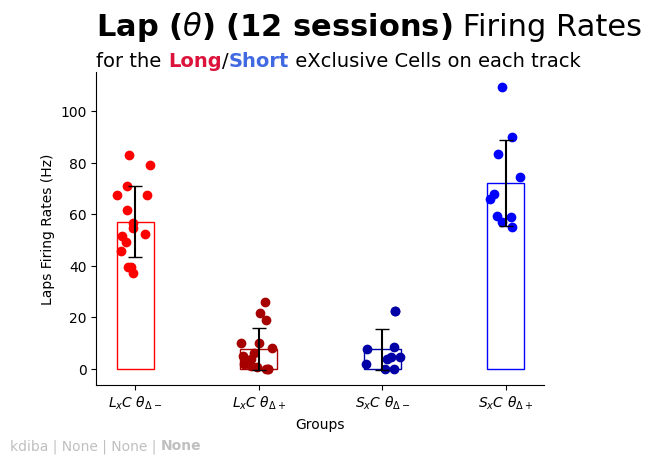

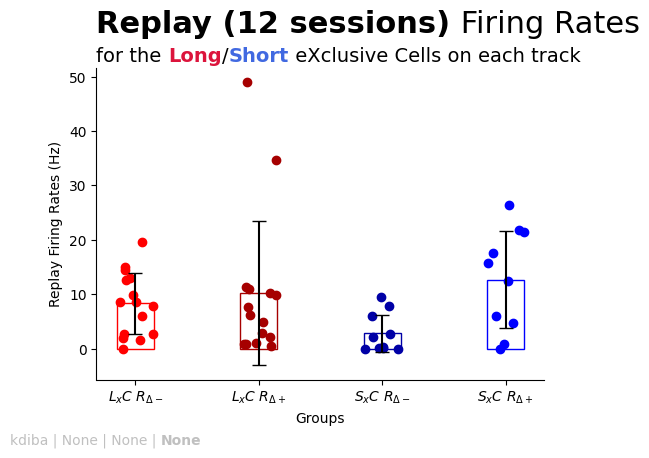

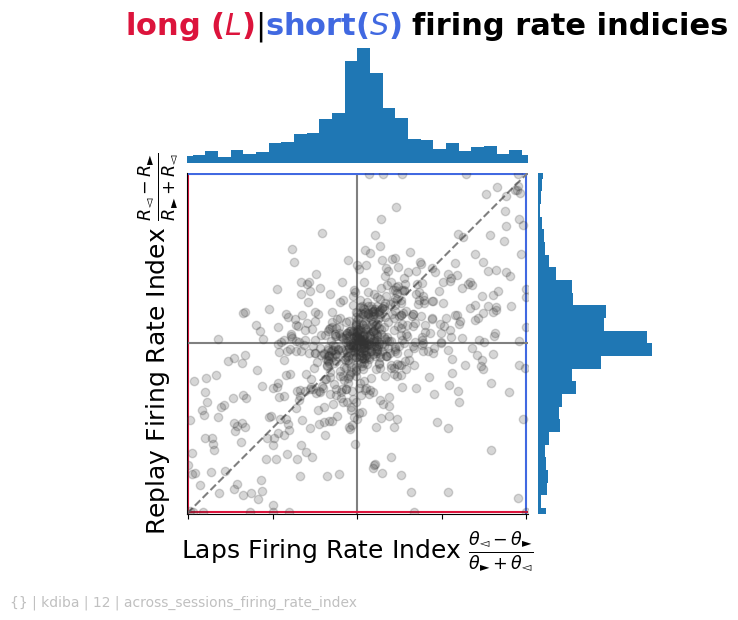

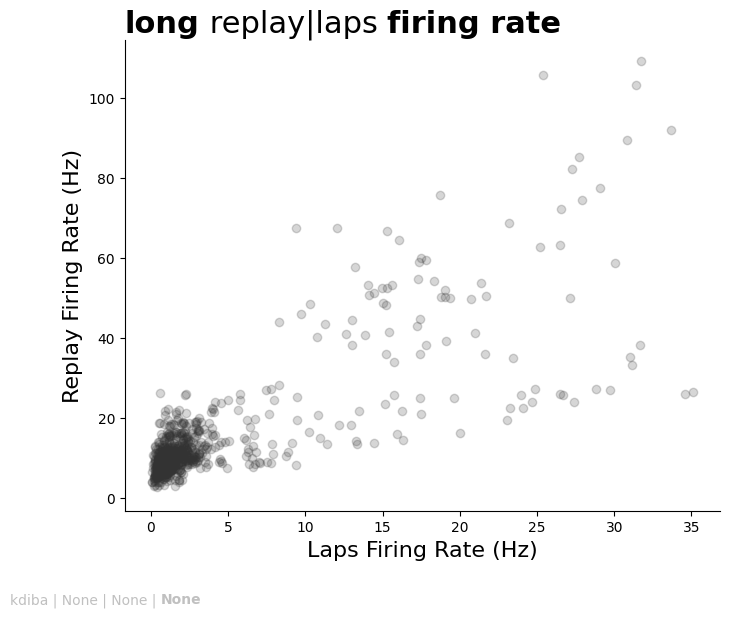

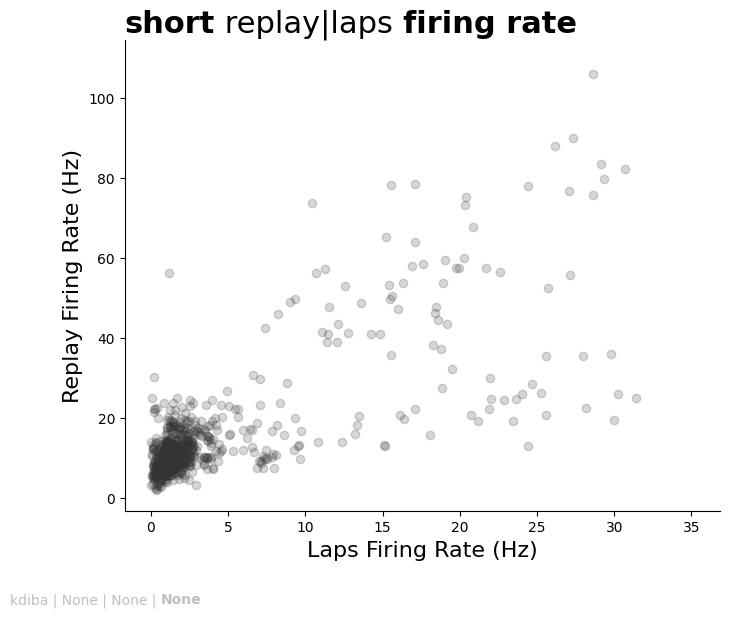

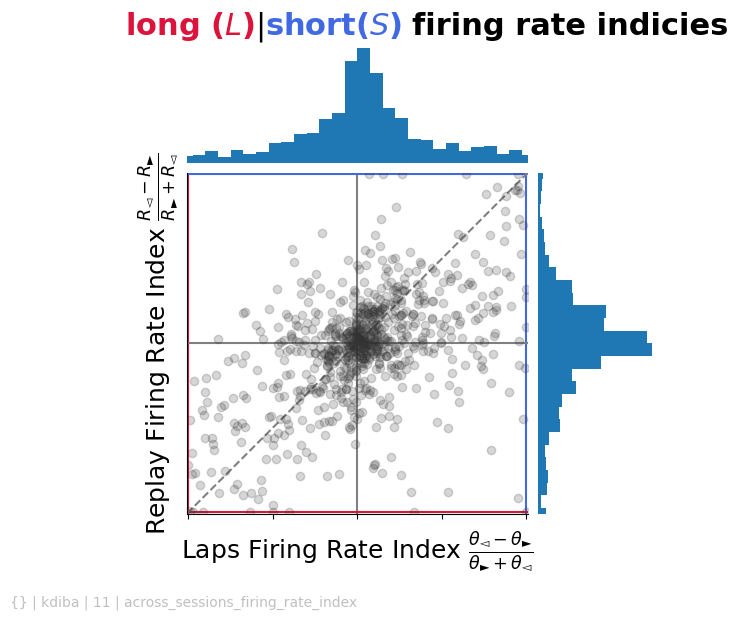

In [7]:
import matplotlib

from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots
from neuropy.utils.matplotlib_helpers import matplotlib_configuration_update
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
# matplotlib.use('Qt5Agg')

def _save_matplotlib_fig(matplotlib_output_container: MatplotlibRenderPlots):

    a_fig_context = matplotlib_output_container.context
    assert len(matplotlib_output_container.saved_figures) == 1
    a_saved_fig_path = matplotlib_output_container.saved_figures[0][0]
    assert a_saved_fig_path.exists()

    if neptuner_run is not None:
        a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
        # a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
        print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
        # neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
        neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_saved_fig_path.as_posix())
        # neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
        

%matplotlib inline


# with matplotlib_configuration_update(is_interactive=False, backend='nbAgg'):
# 'collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-06-11_GL.pkl'

output_path_suffix: str = '2024-09-04_GL'

# graphics_output_dict = AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=global_data_root_parent_path, BATCH_DATE_TO_USE=BATCH_DATE_TO_USE, plotting_enabled=True)
graphics_output_dict = AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix, plotting_enabled=True, output_override_path=Path('../../output'))
matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
matplotlib_output_container: MatplotlibRenderPlots = AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions)

# graphics_output_dict.figures[0]
# graphics_output_dict.context
_save_matplotlib_fig(matplotlib_output_container)



# matplotlib.use('nbAgg')



In [ ]:
plt.close('all')

In [ ]:
graphics_output_dict.saved_figures[0][0] #.plot_data['saved_figures']

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard

fig_to_clipboard(fig)


In [ ]:
# copy_image_to_clipboard(graphics_output_dict['figures'][0])
fig_to_clipboard(matplotlib_output_container.figures[0])

In [ ]:
matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
graphics_output_dict = AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions)

In [ ]:
_save_matplotlib_fig(graphics_output_dict)


In [ ]:
from pyphocorehelpers.assertion_helpers import Assert
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults

# ## Load the saved across-session results:
# Outputs: across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list, neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table

BATCH_DATE_TO_USE = f'2024-09-03'
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{BATCH_DATE_TO_USE}.pkl'

inst_fr_output_file = collected_outputs_directory.joinpath(inst_fr_output_filename).resolve()
Assert.path_exists(inst_fr_output_file)


across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=collected_outputs_directory, inst_fr_output_filename=inst_fr_output_filename)
# across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{BATCH_DATE_TO_USE}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
print(f'num_sessions: {num_sessions}')
# neuron_replay_stats_table


In [ ]:
neptuner.stop()

## 2024-09-04 - Batch Output Files

In [ ]:
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.Filesystem.metadata_helpers import FilesystemMetadata, get_file_metadata
from pyphocorehelpers.Filesystem.path_helpers import discover_data_files, generate_copydict, copy_movedict, copy_file, save_copydict_to_text_file, read_copydict_from_text_file, invert_filedict
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_str_if_file_exists
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import check_output_h5_files, copy_files_in_filelist_to_dest
from pyphoplacecellanalysis.General.Batch.runBatch import ConcreteSessionFolder, BackupMethods
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_path_if_file_exists
from pyphocorehelpers.Filesystem.path_helpers import save_filelist_to_text_file

# a_batch_progress_df = included_session_batch_progress_df.copy()
included_session_contexts
h5_contexts_paths_dict
# h5_session_contexts

debug_print = False
known_global_data_root_parent_paths = [Path(r'/nfs/turbo/umms-kdiba/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/media/halechr/MAX/Data'), Path(r'/Volumes/MoverNew/data')] # , Path(r'/home/halechr/FastData'), Path(r'/home/halechr/turbo/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data')
global_data_root_parent_path = find_first_extant_path(known_global_data_root_parent_paths)
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
## Build Pickle Path:
# Hardcoded included_session_contexts:
included_session_contexts = UserAnnotationsManager.get_hardcoded_good_sessions()
good_session_concrete_folders = ConcreteSessionFolder.build_concrete_session_folders(global_data_root_parent_path, included_session_contexts)

# Output Paths:
included_h5_paths = [get_file_str_if_file_exists(v.pipeline_results_h5) for v in good_session_concrete_folders]
# copy_dict = ConcreteSessionFolder.build_backup_copydict(good_session_concrete_folders, backup_mode=BackupMethods.RenameInSourceDirectory, only_include_file_types=['local_pkl', 'global_pkl'])
check_output_h5_files(included_h5_paths)

## OUTPUTS: included_h5_paths, included_session_contexts, good_session_concrete_folders

included_h5_paths


RESULT_DATE_TO_USE = '2024-09-04'
# RESULT_DATE_TO_USE = '2024-07-02'

# included_file_types_paths_dict = {'h5': included_h5_paths, 'recomputed_inst_fr_comps': []}
# included_file_types_paths_dict['recomputed_inst_fr_comps'] = [get_file_path_if_file_exists(v.output_folder.joinpath(f'{RESULT_DATE_TO_USE}_recomputed_inst_fr_comps_0.0005.h5').resolve()) for v in good_session_concrete_folders]
# included_file_types_paths_dict


In [ ]:
## INPUTS: good_session_concrete_folders, target_dir, BATCH_DATE_TO_USE, custom_file_types_dict
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_path_if_file_exists
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import copy_session_folder_files_to_target_dir

custom_file_types_dict = {'recomputed_inst_fr_comps': (lambda a_session_folder: get_file_path_if_file_exists(a_session_folder.output_folder.joinpath(f'{RESULT_DATE_TO_USE}_recomputed_inst_fr_comps_0.0005.pkl').resolve())),
						#   'PHONEW.evt': (lambda a_session_folder: get_file_path_if_file_exists(a_session_folder.output_folder.joinpath(f'{a_session_folder.context.session_name}.PHONEW.evt').resolve())),
						  }

# target_dir: Path = Path(global_data_root_parent_path)
target_dir: Path = collected_outputs_directory
moved_files_dict_files, (filelist_path, filedict_out_path) = copy_session_folder_files_to_target_dir(good_session_concrete_folders, target_dir=target_dir, RESULT_DATE_TO_USE=BATCH_DATE_TO_USE, custom_file_types_dict=custom_file_types_dict, dry_run=False)

In [ ]:

read_moved_files_dict_files = read_copydict_from_text_file(filedict_out_path, debug_print=False)
read_moved_files_dict_files
# read_moved_files_dict_files
restore_moved_files_dict_files = invert_filedict(read_moved_files_dict_files)
restore_moved_files_dict_files

## Extract `across_sessions_instantaneous_fr_dict` from the computation outputs

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData

across_sessions_recomputed_instantaneous_fr_dict = {}

for a_session_folder in good_session_concrete_folders:
    
    curr_pkl = custom_file_types_dict['recomputed_inst_fr_comps'](a_session_folder)
    if curr_pkl is not None and (curr_pkl.exists()):
        assert curr_pkl.exists()
        print(a_session_folder)
        print(curr_pkl)
        across_sessions_recomputed_instantaneous_fr_dict[a_session_folder.context] = loadData(curr_pkl) # InstantaneousSpikeRateGroupsComputation

# OUTPUT:  across_sessions_recomputed_instantaneous_fr_dict
num_sessions = len(across_sessions_recomputed_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

## Outputs: across_sessions_instantaneous_fr_dict, across_sessions_recomputed_instantaneous_fr_dict
across_session_result_long_short_recomputed_inst_firing_rate_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{BATCH_DATE_TO_USE}.pkl'
AcrossSessionsResults.save_across_sessions_data(across_sessions_instantaneous_fr_dict=across_sessions_recomputed_instantaneous_fr_dict, global_data_root_parent_path=collected_outputs_directory.resolve(),
                                                 inst_fr_output_filename=across_session_result_long_short_recomputed_inst_firing_rate_filename)
